In [55]:
import google.auth
import googleapiclient.discovery
from googleapiclient import discovery
import pandas as pd
from IPython.display import JSON
import requests
from config import youtube_api_key
requests.__version__
import json

import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
channel_ids = ['UCuKlFRtMIlUKuvefJ-YwUtw', 
               #more channels here
              ]

In [57]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = discovery.build(
    api_service_name, api_version, developerKey=youtube_api_key)

request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id=",".join(channel_ids)
)
response = request.execute()

print(response)

{'kind': 'youtube#channelListResponse', 'etag': 'igsqYrd7W9BihMBJw0DGGVK_OuU', 'pageInfo': {'totalResults': 1, 'resultsPerPage': 5}, 'items': [{'kind': 'youtube#channel', 'etag': 'oeoct72erxP6rCLNIE5hvBtyUOA', 'id': 'UCuKlFRtMIlUKuvefJ-YwUtw', 'snippet': {'title': 'HugoX ChugoX', 'description': 'Historia del Perú, ciencias sociales, humanidades, ciencias de la comunicación, tops, curiosidades peruanas y opiniones de actualidad.\nPuedes colaborar con la creación de más vídeos culturales mediante nuestra cuenta en Patreon: www.patreon.com/soyHugoX\nCorreo para consultas empresariales y de patrocinio:\nxavier.pillco@yahoo.com\nPaypal: xavier.pillco@yahoo.com\nTarifa para publicidad: https://efir.io/es/youtube/HugoX+ChugoX', 'customUrl': '@hugoxchugox', 'publishedAt': '2007-12-23T23:52:18Z', 'thumbnails': {'default': {'url': 'https://yt3.ggpht.com/ytc/AL5GRJVbUUwvs_jby1fdY3_C2K3bEAKhN9NPnUGoRKI3Tw=s88-c-k-c0x00ffffff-no-rj', 'width': 88, 'height': 88}, 'medium': {'url': 'https://yt3.ggpht.

In [58]:
def get_channel_stats(youtube, channel_ids):
    all_data= []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()
    
    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos':item['statistics']['videoCount'],
                'playlistId':item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
    return(pd.DataFrame(all_data))

In [59]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [60]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,HugoX ChugoX,900000,98467338,366,UUuKlFRtMIlUKuvefJ-YwUtw


In [61]:
playlist_id = "UUuKlFRtMIlUKuvefJ-YwUtw"

def get_video_ids(youtube, playlist_id):
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId="UUuKlFRtMIlUKuvefJ-YwUtw",
        maxResults = 50
    )
    response = request.execute()
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken') 
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                part="snippet,contentDetails",
                playlistId="UUuKlFRtMIlUKuvefJ-YwUtw",
                maxResults = 50,
                pageToken = next_page_token)
        response = request.execute()
        
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        
        next_page_token = response.get('nextPageToken')
    
    return video_ids

In [67]:
video_ids = get_video_ids(youtube, playlist_id)

In [68]:
video_ids

['-9DyEYcUTqI',
 'bNqR4QDZvHY',
 'QblYEeGSe4g',
 'heB4y3MPTkA',
 'b4F_U0DfgLg',
 'NWuGtB5w7Sw',
 'nnQXooOcvFA',
 'f-Nz3eIRWgE',
 'YLMDF4mVm3I',
 'vTgoZbaanAE',
 'syMGr9H1LL4',
 'pBdfoTv0XG4',
 '0Fl21dyTi5I',
 'g3zQAny1sRE',
 'wAtkxFL28Dg',
 'K6vAyDKr9fA',
 'XQSDyexWmAw',
 'Gp9_2ouQ1Aw',
 'amZzQiuuOM4',
 'XtnTZFkyMRg',
 '4Yf1T61SHkI',
 'phpDYOy7LeQ',
 'NduzTbOYbK8',
 'Cl86duyclUQ',
 '8MMXWlcb1Vs',
 'lclYdMgakQs',
 'Z0Ialuj3AJY',
 '1LzSAv4wdSY',
 'g-o6-TCZ7Ks',
 '6DT3zX_sb3M',
 'R1S1WzLjz1I',
 'i4dvieVSbWo',
 'TKBvL89kJpE',
 'lzz3HdkQIZo',
 'VjfBlwG4Mbs',
 'pdh5Cm9NhUI',
 '3abNMcnFyf0',
 'ZKxS4wWKGKY',
 'LC03Hl7etQs',
 'BPMVbufXi_s',
 'FgczRQ-AZRo',
 'rqv4xVk2y8M',
 '3uYtK48Mm_w',
 '-ZxIkfAxutc',
 'Md4Wj_LMRA0',
 'Pd0ou9qDFQo',
 'v9mQjG2Sc7E',
 '_bHcpZgVhoM',
 'YSwQNpkZ7mg',
 'xxlszIrf8wo',
 'ApduuCOGhEs',
 'U6KrvlNUZT0',
 'V7mx8qoF1xE',
 'jJxFJos6mio',
 'iFS5WnwqoWM',
 'ksvjaEoUT_I',
 'jYtr1HvfMP0',
 'rlVJkW2Z6jk',
 '0Ub42bd4Qzc',
 'VB-lrSiYTQc',
 'Vz5uQw9SHt4',
 'gCehuJS9JsI',
 'jk1y7t

In [63]:
len(video_ids)

367

In [71]:
def get_video_details(youtube, video_ids):
    
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):    
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()


        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails':['duration','definition','caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']
    
        for k in stats_to_keep.keys():
            for v in stats_to_keep[k]:
                try: 
                    video_info[v] = video[k][v]
                except: 
                    video_info[v] = None

        all_video_info.append(video_info)
        
    return pd.DataFrame(all_video_info)

In [74]:
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,xxlszIrf8wo,HugoX ChugoX,"GRACIAS A ESTE INCA, PERÚ TIENE LAS FRONTERAS ...",Pachacútec tomó una decisión de vital importan...,"[hugox chugox, historia del peru hugox, hugo x...",2022-02-18T00:30:14Z,41955,2311,None,164,PT10M47S,hd,false
1,wjsWHBItCro,HugoX ChugoX,Reactivando el Turismo interno. Así está la si...,Turismo en pandemia es algo que poco a poco se...,"[hugox chugox, hugo xavier pillco, hugox chugo...",2021-01-08T23:30:11Z,25489,1353,None,216,PT13M26S,hd,false
2,7K7zNUgTEzc,HugoX ChugoX,"¿CÓMO viven en una ISLA a 4,000 msnm? | TAQUIL...",APÓYAME EN PATREON ► https://goo.gl/Q5pmJ5\n\n...,"[hugox chugox, taquile, uros, islas flotantes ...",2019-10-18T00:29:38Z,26406,1838,None,168,PT11M7S,hd,false
3,zLtp52BmFcY,HugoX ChugoX,COMBATE de ANGAMOS | ¿Por qué conmemoramos una...,Suscribirse para más cultura ► http://goo.gl/7...,"[miguel grau, miguel grau documental, combate ...",2018-10-09T07:48:37Z,141238,7239,None,1022,PT6M18S,hd,false
4,9DPM_6cLAOQ,HugoX ChugoX,¿No existió la BATALLA DE AYACUCHO? ¿Fue nefas...,MI CANAL SECUNDARIO ► https://goo.gl/BMU5v1\nS...,"[hugox chugox, Historia, sucre, bolívar, indep...",2017-12-10T03:11:32Z,328378,10325,None,1225,PT10M28S,hd,false
5,eqWZFMIxYPc,HugoX ChugoX,¿SABES IDENTIFICAR A LAS PERSONAS DE ESTA FOTO...,SSuscribirse para más cultura ► http://goo.gl/...,"[hugox chugox, abimael, guzman, movadef, mrta,...",2017-04-18T23:24:57Z,170704,9681,None,1513,PT11M36S,hd,false
6,RP6sko-J-0I,HugoX ChugoX,NO ME DAN MI TARJETA DEL BCP POR BORRACHO (Tro...,Suscribirse ► http://goo.gl/7Qeib8\nApóyame e...,"[tarjeta, bcp, troll, broma telefonica, broma,...",2015-07-26T20:47:09Z,35538,1323,None,121,PT7M27S,hd,false
7,KpY8yAH1jFk,HugoX ChugoX,Heavy Condor Pasa (versión metal Guitar Pro RS...,Versión Thrash y Heavy del Condor Pasa. Tema o...,"[heavy condor pasa, el condor pasa, musica and...",2012-06-17T04:27:01Z,9808,306,None,47,PT8M3S,sd,false


In [75]:
video_df.tail()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
3,zLtp52BmFcY,HugoX ChugoX,COMBATE de ANGAMOS | ¿Por qué conmemoramos una...,Suscribirse para más cultura ► http://goo.gl/7...,"[miguel grau, miguel grau documental, combate ...",2018-10-09T07:48:37Z,141238,7239,None,1022,PT6M18S,hd,false
4,9DPM_6cLAOQ,HugoX ChugoX,¿No existió la BATALLA DE AYACUCHO? ¿Fue nefas...,MI CANAL SECUNDARIO ► https://goo.gl/BMU5v1\nS...,"[hugox chugox, Historia, sucre, bolívar, indep...",2017-12-10T03:11:32Z,328378,10325,None,1225,PT10M28S,hd,false
5,eqWZFMIxYPc,HugoX ChugoX,¿SABES IDENTIFICAR A LAS PERSONAS DE ESTA FOTO...,SSuscribirse para más cultura ► http://goo.gl/...,"[hugox chugox, abimael, guzman, movadef, mrta,...",2017-04-18T23:24:57Z,170704,9681,None,1513,PT11M36S,hd,false
6,RP6sko-J-0I,HugoX ChugoX,NO ME DAN MI TARJETA DEL BCP POR BORRACHO (Tro...,Suscribirse ► http://goo.gl/7Qeib8\nApóyame e...,"[tarjeta, bcp, troll, broma telefonica, broma,...",2015-07-26T20:47:09Z,35538,1323,None,121,PT7M27S,hd,false
7,KpY8yAH1jFk,HugoX ChugoX,Heavy Condor Pasa (versión metal Guitar Pro RS...,Versión Thrash y Heavy del Condor Pasa. Tema o...,"[heavy condor pasa, el condor pasa, musica and...",2012-06-17T04:27:01Z,9808,306,None,47,PT8M3S,sd,false


In [104]:
def get_comments_in_videos(youtube, video_ids):
    all_comments = []
    for video_id in video_ids:
        try:
            request = youtube.commentThreads().list(
            part="snippet,replies",
            videoId=video_id,
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}
        
            all_comments.append(comments_in_video_info)
        
        except:
            print('Could not get comments for video' + video_id)
        
    return pd.DataFrame(all_comments)

In [105]:
comments_df = get_comments_in_videos(youtube, video_ids)
comments_df

Could not get comments for videopBdfoTv0XG4
Could not get comments for videoJDmtDcb3qVU
Could not get comments for video1iBn7WycIxg


,video_id,comments
0,-9DyEYcUTqI,"[Excelente video muy informativo ,gracias amig..."
1,bNqR4QDZvHY,[Si es asno castillo no hubiera dado el golpe ...
2,QblYEeGSe4g,"[""era como Venezuela ahora mismo"" xd?, El prob..."
3,heB4y3MPTkA,[por favor HugoX deberías hacer un video sobre...
4,b4F_U0DfgLg,"[ES UN INVENTO DE CHIQUEHUANCA, el vicepresi d..."
...,...,...
359,jv5UsAqo0p0,[No vayas a eliminar tus videos más antiguos. ...
360,RN7Na36Qab0,"[No conocía esa faceta de Hugox😁, Estás dicien..."
361,Pva82ci8gIU,"[el lado oscuro de hugox, Que bien lo mueve hu..."
362,CGmo9HKw1lU,"[:0 me sorprendes no sabia que eras metalero, ..."


In [106]:
comments_df['comments'][0]

['Excelente video muy informativo ,gracias amigo',
 'Felicitaciones Hugo, tu video es sumamente didáctico. Por cierto, es lo que se debería enseñar a todos los estudiantes de la costa central y sur del Perú; sin embargo, los cambios tan absurdos en el Currículo Nacional, ha quitado tantos temas al punto que hoy, los estudiantes egresan sin saber casi nada.',
 'No engañes al publico, el ciclon  yaku no llego ni llegara al Perù, esto es simplemente  el fenómeno del niño, ya especialistas han desmentido esto del "CILON YAKU", ya que al gobierno del Perú le conviene que sea el CICLON YAKU ya que el fenómeno del niño ya tenia dinero reservado pero como lo gastaron sin preveer no les quedo mas remedio que inventar esto',
 'Te.  Felicito. Tocayo.  Por.  Tu. Explicacion.  Del   ciclón.  Yaku.    Sigue.  Con.  Tu.  Programa.   Olvida.   A. Los.  Envidiosos',
 'Excelente video. Gracias por compartir\nBENDICIONES',
 'Nuevo?, quizá sea del Proyecto HARP, un fenómeno direccionado.',
 'Muchos hablan

In [107]:
## DATA PREPROCESSING

In [108]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags              False
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [109]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [110]:
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis=1)

In [111]:
## Publish day in the week
from dateutil import parser
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['publishedDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))


In [112]:
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))


In [113]:
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,0 days 00:10:47,PT10M47S
1,0 days 00:13:26,PT13M26S
2,0 days 00:11:07,PT11M7S
3,0 days 00:06:18,PT6M18S
4,0 days 00:10:28,PT10M28S
5,0 days 00:11:36,PT11M36S
6,0 days 00:07:27,PT7M27S
7,0 days 00:08:03,PT8M3S


In [134]:
video_df['durationSecs'].dtypes

dtype('<m8[ns]')

In [114]:
## Ad tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [115]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName,durationSecs,tagCount
0,xxlszIrf8wo,HugoX ChugoX,"GRACIAS A ESTE INCA, PERÚ TIENE LAS FRONTERAS ...",Pachacútec tomó una decisión de vital importan...,"[hugox chugox, historia del peru hugox, hugo x...",2022-02-18 00:30:14+00:00,41955.0,2311.0,NaN,164.0,PT10M47S,hd,false,Friday,0 days 00:10:47,18
1,wjsWHBItCro,HugoX ChugoX,Reactivando el Turismo interno. Así está la si...,Turismo en pandemia es algo que poco a poco se...,"[hugox chugox, hugo xavier pillco, hugox chugo...",2021-01-08 23:30:11+00:00,25489.0,1353.0,NaN,216.0,PT13M26S,hd,false,Friday,0 days 00:13:26,13
2,7K7zNUgTEzc,HugoX ChugoX,"¿CÓMO viven en una ISLA a 4,000 msnm? | TAQUIL...",APÓYAME EN PATREON ► https://goo.gl/Q5pmJ5\n\n...,"[hugox chugox, taquile, uros, islas flotantes ...",2019-10-18 00:29:38+00:00,26406.0,1838.0,NaN,168.0,PT11M7S,hd,false,Friday,0 days 00:11:07,12
3,zLtp52BmFcY,HugoX ChugoX,COMBATE de ANGAMOS | ¿Por qué conmemoramos una...,Suscribirse para más cultura ► http://goo.gl/7...,"[miguel grau, miguel grau documental, combate ...",2018-10-09 07:48:37+00:00,141238.0,7239.0,NaN,1022.0,PT6M18S,hd,false,Tuesday,0 days 00:06:18,10
4,9DPM_6cLAOQ,HugoX ChugoX,¿No existió la BATALLA DE AYACUCHO? ¿Fue nefas...,MI CANAL SECUNDARIO ► https://goo.gl/BMU5v1\nS...,"[hugox chugox, Historia, sucre, bolívar, indep...",2017-12-10 03:11:32+00:00,328378.0,10325.0,NaN,1225.0,PT10M28S,hd,false,Sunday,0 days 00:10:28,11
5,eqWZFMIxYPc,HugoX ChugoX,¿SABES IDENTIFICAR A LAS PERSONAS DE ESTA FOTO...,SSuscribirse para más cultura ► http://goo.gl/...,"[hugox chugox, abimael, guzman, movadef, mrta,...",2017-04-18 23:24:57+00:00,170704.0,9681.0,NaN,1513.0,PT11M36S,hd,false,Tuesday,0 days 00:11:36,14
6,RP6sko-J-0I,HugoX ChugoX,NO ME DAN MI TARJETA DEL BCP POR BORRACHO (Tro...,Suscribirse ► http://goo.gl/7Qeib8\nApóyame e...,"[tarjeta, bcp, troll, broma telefonica, broma,...",2015-07-26 20:47:09+00:00,35538.0,1323.0,NaN,121.0,PT7M27S,hd,false,Sunday,0 days 00:07:27,8
7,KpY8yAH1jFk,HugoX ChugoX,Heavy Condor Pasa (versión metal Guitar Pro RS...,Versión Thrash y Heavy del Condor Pasa. Tema o...,"[heavy condor pasa, el condor pasa, musica and...",2012-06-17 04:27:01+00:00,9808.0,306.0,NaN,47.0,PT8M3S,sd,false,Sunday,0 days 00:08:03,9


In [116]:
#EDA

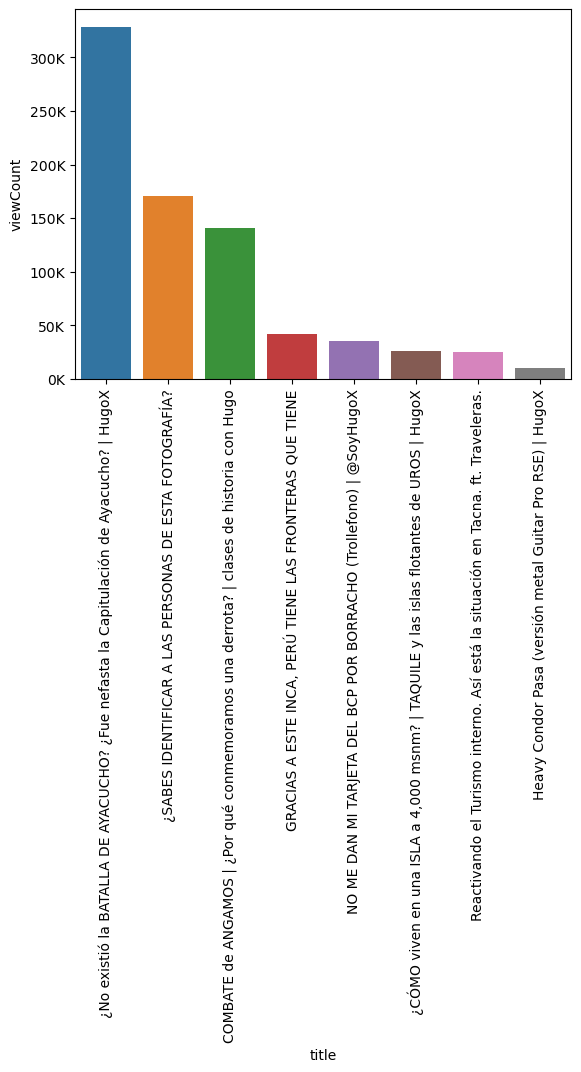

In [122]:
# Best performing videos
import matplotlib.ticker as ticker
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

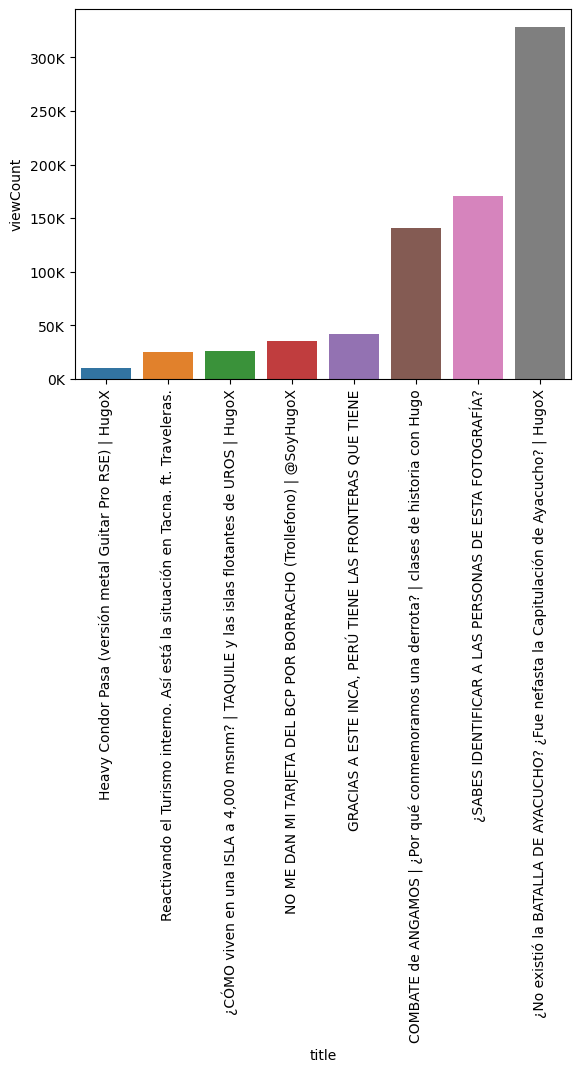

In [123]:
# Worst performing videos
ax = sns.barplot(x = 'title', y = 'viewCount', data=video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

C:\Users\andca\anaconda3\envs\PythonData\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

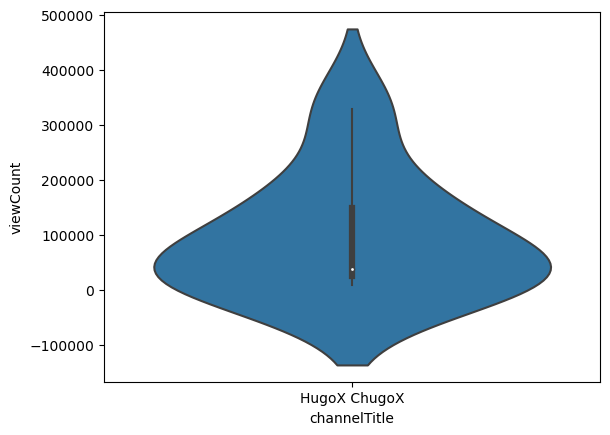

In [125]:
# View distribution per video
sns.violinplot(video_df['channelTitle'], video_df['viewCount'])


In [126]:
# Views vs likes and comments

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

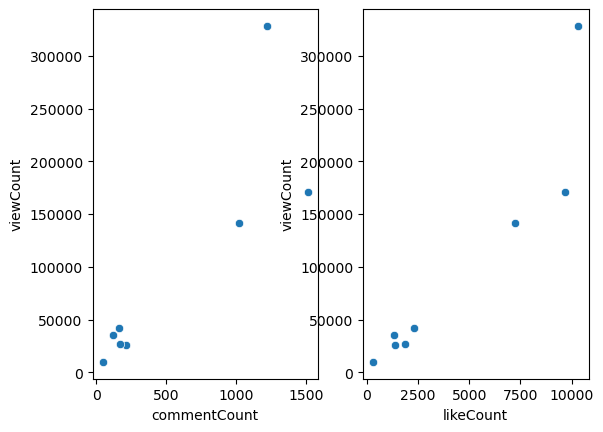

In [127]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

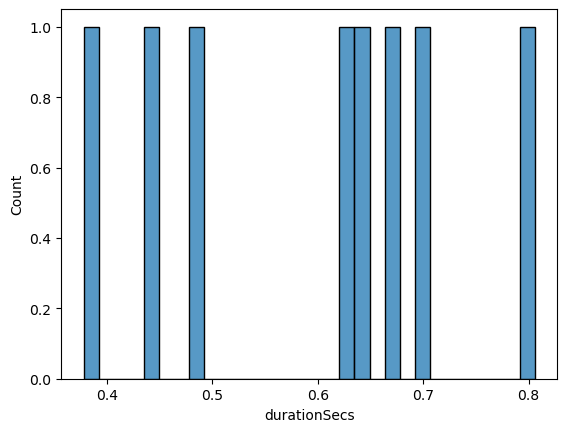

In [138]:
# Convert durationSecs to seconds
video_df['durationSecs'] = video_df['durationSecs'] / 1000

# Video duration
sns.histplot(data=video_df[video_df['durationSecs'] < 10000], x="durationSecs", bins=30)

<AxesSubplot:xlabel='durationSecs', ylabel='likeCount'>

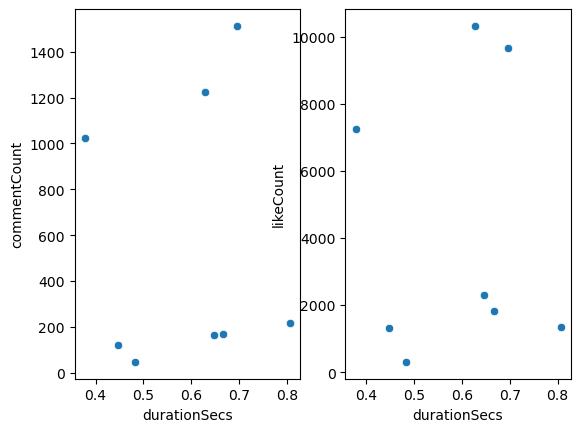

In [139]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

<AxesSubplot:xlabel='title_length', ylabel='viewCount'>

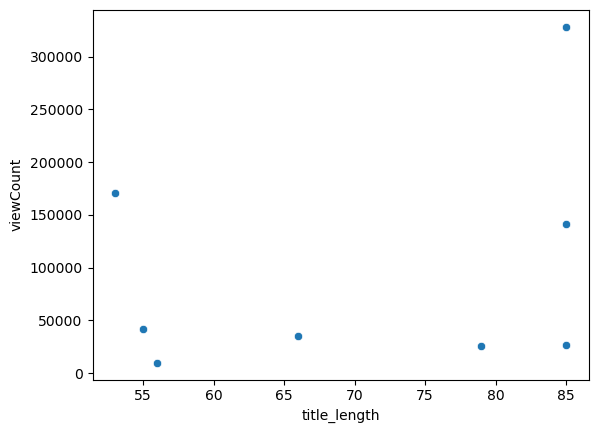

In [143]:
video_df['title_length'] = video_df['title'].apply(len)
sns.scatterplot(data = video_df, x = "title_length", y = "viewCount")
